<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/Navec_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install pymorphy2 --quiet
!pip install navec --quiet
!pip install wget --quiet

In [33]:
import wget
import os
import sys
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymorphy2
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from navec import Navec

# **Get cleaned dataset**

In [34]:
url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/data_cleaned_RU.csv'

PATH_CLEANED_DATASET = 'data_cleaned_RU.csv'
if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

**Parse**

In [35]:
df = pd.read_csv(PATH_CLEANED_DATASET)
df=df.astype({'toxic': 'int64'})
df.sample(10)

,comment,toxic
12220,вполне возможный история,0
911,приходить умный человек помогать он научиться ...,0
9181,ха ха про без обида посмотреть программа подго...,0
7716,есть ещё кожаный рамка прострочка клавиша выкл...,0
10219,не ну перебор если иметь деньга то где то,0
6364,посмотреть ваш нюксель пуксель последний видео...,1
11028,сейчас бы сравнивать корпорация государство уч...,0
3096,остаться подождать год,0
12313,короче не наш поход удалить фейк быть наверное...,1
5922,эх помнить в партенить лазать через дыра забор...,0


In [36]:
print("max :",df.comment.str.len().max())
print("min :",df.comment.str.len().min())
print("mean :",df.comment.str.len().mean())

max : 6728
min : 1
mean : 159.97800444074383


max:  890
min:  0
mean:  24.667291146267


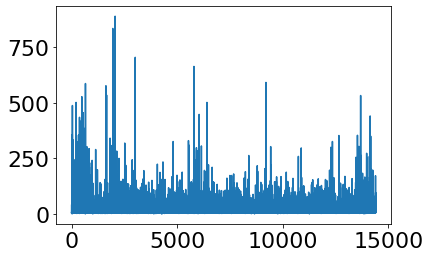

In [37]:
import statistics

print("max: ",max(list(map(lambda comment: len(comment.split()),df.comment))))
print("min: ",min(list(map(lambda comment: len(comment.split()),df.comment))))
print("mean: ",statistics.mean(list(map(lambda comment: len(comment.split()),df.comment))))
plt.plot(df.comment.index,list(map(lambda comment: len(comment.split()),df.comment)))

In [38]:
sentences = df.comment.values
labels = df.toxic.values

**Split**

In [39]:
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.2, random_state=42)   # .15  .2
print(X_train.shape)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=42) # .1764705882352941   .25

(11529,)


In [40]:
X_train.shape

(8646,)

In [41]:
type(X_train)

numpy.ndarray

In [42]:
from navec import Navec

url = 'https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar'
PATH_NAVEC = 'navec_hudlit_v1_12B_500K_300d_100q.tar'

if not os.path.exists(PATH_NAVEC):
    wget.download(url)
navec = Navec.load(PATH_NAVEC)

In [43]:
NAVEC_UNK= '<unk>'
NAVEC_PAD= '<pad>'
DIMENSION_EMBEDDING=navec.get('<unk>').shape[0]

In [44]:
def vectorize_sentence(sentence: str, vectorizer=navec,unc_token =NAVEC_UNK, pad_token = NAVEC_PAD, max_sequence_length=30) -> np.array:
    tokens = sentence.split()
    embedd_tokens = [navec.get(t, navec[unc_token]) for t in tokens[:max_sequence_length]]
    if len(embedd_tokens) < max_sequence_length:
        embedd_tokens += [navec[pad_token]] * (max_sequence_length - len(embedd_tokens))
    return np.array(embedd_tokens)

In [45]:
# получить длину(количество слов) отзывов в 75% датасета
sequence_length=int(round(np.percentile(list(map(lambda sentence: len(sentence.split()), X_train)), 75)))

In [46]:
sequence_length

28

In [47]:
navec.get('<unk>').shape[0]

300

In [48]:
X_train = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=navec,
        unc_token =NAVEC_UNK,
        pad_token = NAVEC_PAD,
        max_sequence_length=sequence_length),
    X_train.flatten()
    )
))

X_val = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=navec,
        unc_token =NAVEC_UNK,
        pad_token = NAVEC_PAD,
        max_sequence_length=sequence_length),
    X_val.flatten()
    )
))

X_test = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=navec,
        unc_token =NAVEC_UNK,
        pad_token = NAVEC_PAD,
        max_sequence_length=sequence_length),
    X_test.flatten()
    )
))


In [49]:
X_train.shape

(8646, 28, 300)

**Build RNN model**

Model: "Glove-Navec_BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spatial_dropout1d_1 (Spatia  (None, 28, 300)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 28, 512)          1140736   
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 512)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                                

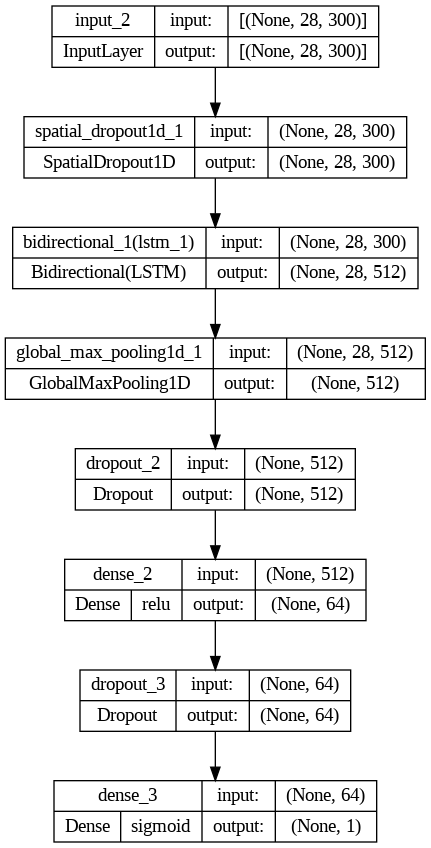

In [50]:
import tensorflow as tf
from tensorflow.keras.metrics import TruePositives,FalsePositives,TrueNegatives,FalseNegatives,BinaryAccuracy,Precision,Recall,AUC,AUC
from tensorflow.keras import Sequential,losses
from tensorflow.keras.layers import Input, Dense, Dropout,Bidirectional,LSTM,GlobalMaxPool1D,SpatialDropout1D
from tensorflow.keras.utils import plot_model

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      AUC(name='prc', curve='PR'), # precision-recall curve
]

SEED = 42
SPLIT = 0.2
EPOCHS = 20
BATCH_SIZE = 512
MODEL_NAME = 'Glove-Navec_BiLSTM'

negative_count, neutral_count = np.bincount(y_train)

initial_output_bias = tf.keras.initializers.Constant(
    np.log([neutral_count/negative_count])
)

model = tf.keras.Sequential(
    [
    Input(shape=(sequence_length, DIMENSION_EMBEDDING,),dtype=tf.float32),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(256, recurrent_dropout=0.1, return_sequences=True)),
    GlobalMaxPool1D(),
    Dropout(rate=0.5, seed=SEED),
    Dense(64, activation='relu'),
    Dropout(rate=0.5, seed=SEED),
    Dense(1,bias_initializer=initial_output_bias,activation='sigmoid'),
]
,name=MODEL_NAME)

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=METRICS
)
model.summary()

plot_model(model,
           to_file='model.png',
           show_shapes=True,
           show_layer_names=True,
           layer_range=None,
            show_layer_activations=True)

In [51]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

def calculate_weights(pos_count, neg_count):
    total = pos_count + neg_count
    return {
        0: (1 / neg_count) * total / 2.0,
        1: (1 / pos_count) * total / 2.0
    }

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val,y_val),
    callbacks=[early_stopping],
    class_weight=calculate_weights(neutral_count, negative_count),
)

Epoch 1/20
17/17 [==============================] - 14s 455ms/step - loss: 0.5264 - tp: 1834.0000 - fp: 993.0000 - tn: 4741.0000 - fn: 1078.0000 - accuracy: 0.7605 - precision: 0.6487 - recall: 0.6298 - auc: 0.8193 - prc: 0.7128 - val_loss: 0.3315 - val_tp: 796.0000 - val_fp: 216.0000 - val_tn: 1692.0000 - val_fn: 179.0000 - val_accuracy: 0.8630 - val_precision: 0.7866 - val_recall: 0.8164 - val_auc: 0.9275 - val_prc: 0.8703
Epoch 2/20
17/17 [==============================] - 8s 505ms/step - loss: 0.3489 - tp: 2452.0000 - fp: 713.0000 - tn: 5021.0000 - fn: 460.0000 - accuracy: 0.8643 - precision: 0.7747 - recall: 0.8420 - auc: 0.9269 - prc: 0.8636 - val_loss: 0.2913 - val_tp: 796.0000 - val_fp: 166.0000 - val_tn: 1742.0000 - val_fn: 179.0000 - val_accuracy: 0.8803 - val_precision: 0.8274 - val_recall: 0.8164 - val_auc: 0.9427 - val_prc: 0.8959
Epoch 3/20
17/17 [==============================] - 10s 574ms/step - loss: 0.3269 - tp: 2545.0000 - fp: 707.0000 - tn: 5027.0000 - fn: 367.0000 

**Save model**

In [52]:
model.save(MODEL_NAME)

In [53]:
pred = model.predict(X_test).flatten()

91/91 [==============================] - 3s 32ms/step


In [54]:
pred

array([0.9971825 , 0.00657164, 0.00474243, ..., 0.99373525, 0.99506146,
       0.00772621], dtype=float32)

In [55]:
pred

array([0.9971825 , 0.00657164, 0.00474243, ..., 0.99373525, 0.99506146,
       0.00772621], dtype=float32)

In [56]:
threshold =0.5
pred = np.where(pred<threshold,0,1)

In [57]:
pred

array([1, 0, 0, ..., 1, 1, 0])

In [58]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.rcParams.update({'font.size': 22})
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  print("Accuracy: {0:.2f} %".format(100 * accuracy_score(y_test, pred)))
  print("Recall: {0:.2f} %".format(100 * recall_score(y_test, pred)))
  print("Precision: {0:.2f} %".format(100 * precision_score(y_test, pred)))
  print("F1-score: {0:.2f} % \n".format(100 * f1_score(y_test, pred)))
  precision, recall, f1score = precision_recall_fscore_support(y_test, pred, average='macro')[:3]
  print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
  print(classification_report(y_test, pred,digits=4))  
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

Accuracy: 90.39 %
Recall: 88.39 %
Precision: 83.17 %
F1-score: 85.70 % 

precision: 0.886919196483152, recall: 0.8987496548731906, f1score: 0.8923263527143139
              precision    recall  f1-score   support

           0     0.9422    0.9136    0.9277      1944
           1     0.8317    0.8839    0.8570       939

    accuracy                         0.9039      2883
   macro avg     0.8869    0.8987    0.8923      2883
weighted avg     0.9062    0.9039    0.9046      2883

True Negatives:  1776
False Positives:  168
False Negatives:  109
True Positives:  830


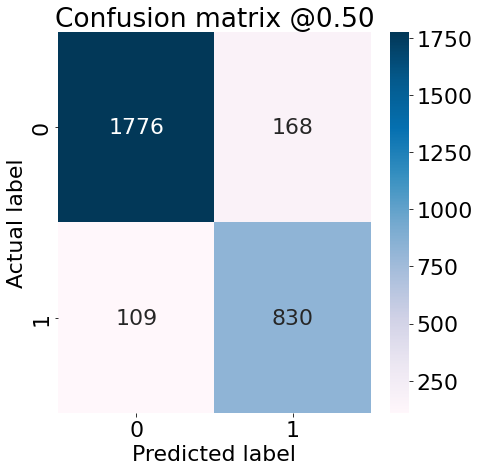

In [59]:
plot_cm(y_test, pred)

In [60]:
def plot_metrics(history):
  metrics = ['loss','accuracy', 'precision', 'recall','auc','prc']
  plt.figure(figsize=(20, 20), tight_layout={'h_pad': 3})
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric],  label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],label='Val')
    plt.xlabel('Epoch', fontdict={'fontsize': 15})
    plt.title(name, fontdict={'fontsize': 21, 'fontweight': 500}, pad=20)
    plt.legend(fontsize=21)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

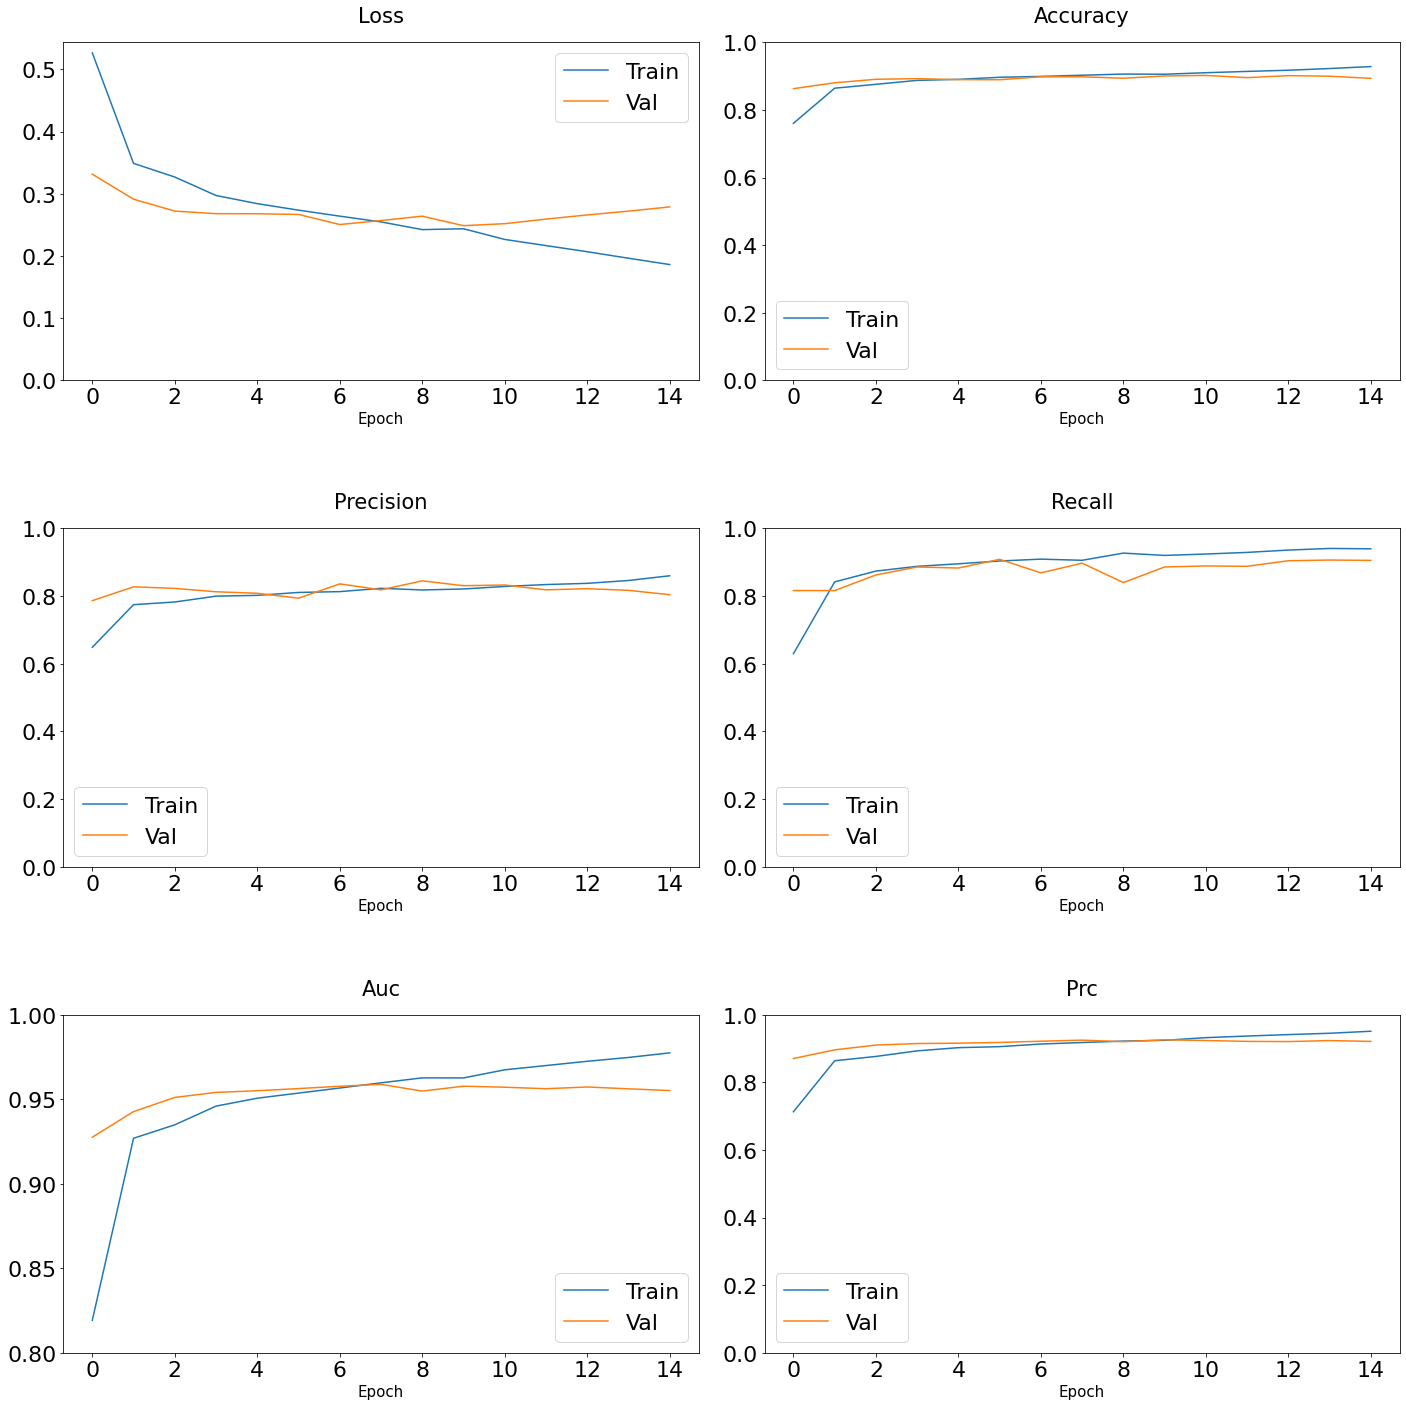

In [61]:
plot_metrics(history)